# Analyzing DTM Results
#https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb

In [227]:
import pickle
import pyLDAvis
import pandas as pd
import seaborn as sns


# Set topic number

In [214]:
model = pickle.load( open("/Users/carlyknight/Documents/Data/FuturePerfect/dynamic_topic_models/topic30.pkl", "rb" ) )
#print model attirbutes
print(model.__dict__.keys())

dict_keys(['dtm_path', 'id2word', 'num_terms', 'num_topics', 'lencorpus', 'prefix', 'time_slices', 'lda_sequence_min_iter', 'lda_sequence_max_iter', 'lda_max_em_iter', 'alpha', 'top_chain_var', 'rng_seed', 'initialize_lda', 'lambda_', 'obs_', 'lhood_', 'gamma_', 'init_alpha', 'init_beta', 'init_ss', 'em_steps', 'influences_time'])


In [215]:
number_topic = model.num_topics
number_topic

30

In [216]:
corpus = pickle.load(open('/Users/carlyknight/Documents/Data/FuturePerfect/dynamic_topic_models/corpus.pkl', 'rb') )

### Topic summary (final time period)

In [217]:
for i in range(0,number_topic):
    topics=model.show_topic(topicid=i, time=75, topn=10)
    topic_words =[word for number, word in topics]
    print("TOPIC ", i, ": ", topic_words)

TOPIC  0 :  ['peopl', 'world', 'live', 'great', 'need', 'american', 'work', 'todai', 'help', 'famili']
TOPIC  1 :  ['oil', 'ga', 'compani', 'petroleum', 'product', 'crude', 'explor', 'develop', 'oper', 'barrel']
TOPIC  2 :  ['year', 'earn', 'industri', 'quarter', 'econom', 'result', 'busi', 'level', 'economi', 'expect']
TOPIC  3 :  ['compani', 'subsidiari', 'oper', 'unit', 'state', 'divis', 'acquir', 'corpor', 'north', 'countri']
TOPIC  4 :  ['price', 'product', 'war', 'govern', 'materi', 'cost', 'suppli', 'year', 'inventori', 'industri']
TOPIC  5 :  ['annual', 'meet', 'held', 'new', 'stockhold', 'york', 'street', 'april', 'sharehold', 'corpor']
TOPIC  6 :  ['busi', 'custom', 'growth', 'market', 'compani', 'futur', 'valu', 'continu', 'opportun', 'servic']
TOPIC  7 :  ['tax', 'year', 'dividend', 'incom', 'earn', 'share', 'net', 'reserv', 'compani', 'charg']
TOPIC  8 :  ['statement', 'report', 'includ', 'result', 'forwardlook', 'compani', 'annual', 'risk', 'financi', 'factor']
TOPIC  9 :

In [218]:
#create top six words
keywords = []

for i in range(0,number_topic):
    topics=model.show_topic(topicid=i, time=75, topn=6)
    words=" ".join([word for number, word in topics])
    keywords.append(words)

# Topic visualization

In [221]:
#data visualization
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=corpus)

In [236]:
from IPython.core.display import HTML

In [237]:
#pyLDAavis
pyLDAvis.enable_notebook()
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/Users/carlyknight/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [12]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
#https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/

# Topics over time
#https://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
#https://radimrehurek.com/gensim/models/ldamodel.html

### open metadata

In [223]:
file_loc = "/Users/carlyknight/Documents/Data/Annual Report/report_paragraphs/future_texts/"

#limit to over 1930
metadata = pd.read_csv(file_loc + "metadata_futureperfect.csv") 
metadata = metadata[(metadata['Year'] >= 1930)]
metadata['text_filename'] = metadata['Filename'].str.replace(".xml", ".txt")

# Get document-topic weights

In [225]:
#create document-topic matrix
num_docs = model.lencorpus
data = []

for j in range(0, num_docs):
    doc_topics = [model.gamma_[j, i] for i in range(0, number_topic)]
    data.append(doc_topics)
    
topic_document_distribution = pd.DataFrame(data)
topic_document_distribution.shape


(33989, 30)

In [235]:
#check to make sure weights load to 1:
sumweights= topic_document_distribution.sum(axis=1)
for i, doc in enumerate(sumweights):
    if doc !=1:
        continue
        #print("Doc ", i, " does not equal 1: ", doc )

In [228]:
#basically loads to 1

#pull in metadata
names = [i for i in metadata['Filename']]
topic_document_distribution['Filename'] = names
years = [i for i in metadata['Year']]
topic_document_distribution['Year'] = years

topic_document_distribution.to_csv("/Users/carlyknight/Dropbox/PROJECTS/ConceptionsofRisk/data/dtm/topic_document_distribution.csv")

#convert dataset to long
dtm = pd.melt(topic_document_distribution, id_vars=["Filename", "Year"], var_name= "topic", value_name='weight')
dtm=dtm.sort_values(by = ["Year", "Filename", "topic"])
print(dtm.head())

            Filename  Year topic    weight
19798   88178299.xml  1930     0  0.000493
53787   88178299.xml  1930     1  0.000493
87776   88178299.xml  1930     2  0.000493
121765  88178299.xml  1930     3  0.000493
155754  88178299.xml  1930     4  0.000493


In [229]:
#put in topic keywords
dfkeys = pd.DataFrame(keywords)
dfkeys.columns = ['keywords']
dfkeys['topic'] = range(0,number_topic)

#merge
dtm=dtm.merge(dfkeys, left_on='topic', right_on='topic')
print(dtm.head())

       Filename  Year topic    weight                              keywords
0  88178299.xml  1930     0  0.000493  peopl world live great need american
1  88178309.xml  1930     0  0.134783  peopl world live great need american
2  88178340.xml  1930     0  0.000149  peopl world live great need american
3  88178352.xml  1930     0  0.000578  peopl world live great need american
4  88178376.xml  1930     0  0.000578  peopl world live great need american


# Summary Statistics

In [230]:
dtm_sum = dtm[dtm['weight'] != 0]

print("Max: {}".format(dtm_sum['weight'].max()))
print("Min: {}".format(dtm_sum['weight'].min()))
print("Average: {}".format(dtm_sum['weight'].mean()))
print("Median: {}".format(dtm_sum['weight'].median()))
print("Most frequent value: {}".format(dtm_sum['weight'].round(3).value_counts().idxmax()))


Max: 0.9956909361069829
Min: 1.540120129370095e-05
Average: 0.03333333333332524
Median: 0.0003663003663003662
Most frequent value: 0.0


# Graph over time

In [231]:
# Get number of docs per year
total_docs = dtm.groupby('Year')['Filename'].apply(lambda x: len(x.unique())).reset_index()
total_docs.columns = ['Year', 'total_docs']

# Group by year and topic id
dtm_avg = dtm.groupby(['Year', 'topic'])['weight'].sum().reset_index()

# Merge dataframes
dtm_avg_1 = dtm_avg.merge(total_docs, on="Year", how="left")

# Compute the mean per topic
dtm_avg_1['average_weight'] = dtm_avg_1['weight'] / dtm_avg_1['total_docs']

#merge in labels
labels= dtm[['topic', 'keywords']].drop_duplicates()
dtm_avg_2 = dtm_avg_1.merge(labels, on='topic')

dtm_time = dtm_avg_2

In [232]:
#Create plot
def create_pointplot(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="Year", y=y_value, kind='point', hue=hue, 
                       col=col, col_wrap=wrap,  size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p


def create_bar(df, y_value, hue=None, col=None, wrap=None, size=5, aspect=1.5, title=""):
    p = sns.factorplot(x="Year", y=y_value, kind='bar', hue=hue, 
                       col=col, col_wrap=wrap, size=size, aspect=aspect, data=df)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    return p


# Plots

/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/carlyknight/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWa

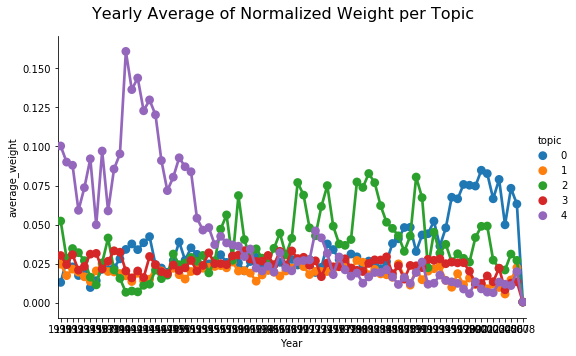

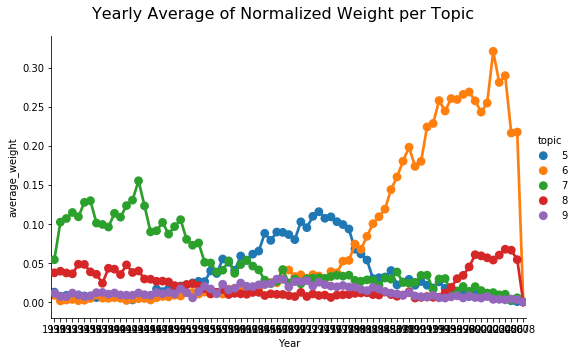

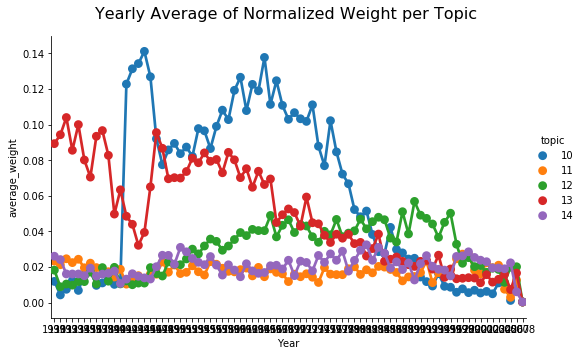

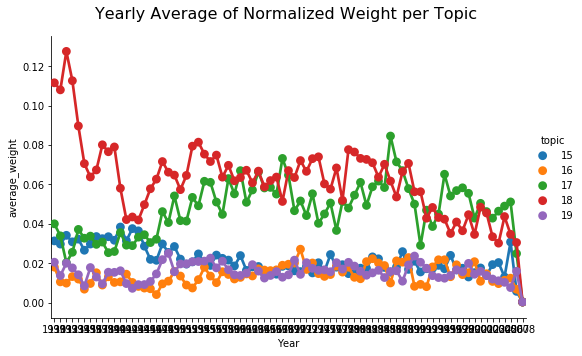

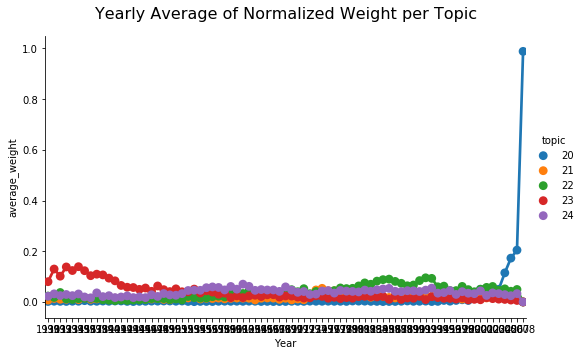

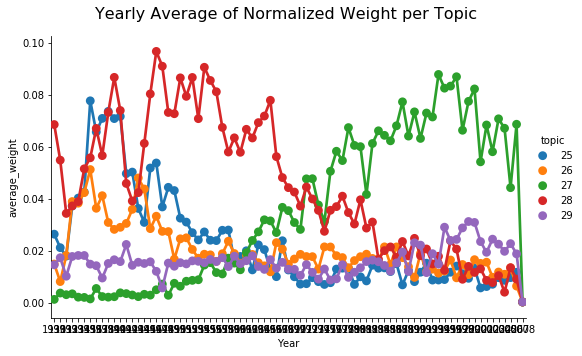

In [233]:
for i in range(0, number_topic, 5):
    dfs = dtm_time[(dtm_time['topic'] >= i) & (dtm_time['topic'] < i +5 )]
    create_pointplot(dfs, 'average_weight', hue="topic",
                title="Yearly Average of Normalized Weight per Topic")
